In [1]:
%matplotlib widget
# Load packages and settings
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.min_rows', 50)
import seaborn as sns


import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = (12,8)
plt.rcParams["image.cmap"] = "tab10"
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.tab10.colors)
fs_label = 16
parameters = {
                'axes.labelsize': fs_label,
                'axes.titlesize': fs_label+4,
                'xtick.labelsize': fs_label,
                'ytick.labelsize': fs_label, 
                'legend.fontsize': fs_label, 
                'lines.markersize': 10,
                'lines.linewidth': 3
             }
plt.rcParams.update(parameters)

from matplotlib import cm # Colormaps
import matplotlib.colors as colors
# cmap = plt.cm.get_cmap('Dark2',len(ageGroups))

import locale
import matplotlib.dates as mdates
locale.setlocale(locale.LC_TIME,"Danish")
# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%b\n%Y'))
# ax1.spines['top'].set_visible(False) 

import os
# import csv
import math

from datetime import date
# import datetime

saveFigures = True
# saveFigures = False
print('saveFigures is set to: '+str(saveFigures))

print('Done loading packages')

# Define running mean functions
def rnMean(data,meanWidth):
    return np.convolve(data, np.ones(meanWidth)/meanWidth, mode='valid')
def rnTime(t,meanWidth):
    return t[math.floor(meanWidth/2):-math.ceil(meanWidth/2)+1]

saveFigures is set to: True
Done loading packages


In [2]:
# Define paths
# rootdir_data = os.getcwd() +"\\..\\DanskeData\\" 
# rootdir_data = "D:\Pandemix\Github\DanskeData\\"
# rootdir_data = "C:\\Users\\rakrpe\\OneDrive - Roskilde Universitet\\Documents\\PandemiX\\GithubRepos\\PandemiX\\DanskeData\\"
rootdir_data = "C:/Users/rakrpe/GithubRepos/PandemiX/DanskeData/"

path_data = rootdir_data + "ssi_data/"
path_dash = rootdir_data + "ssi_dashboard/"
path_vacc = rootdir_data + "ssi_vacc/"
path_figs = os.getcwd() +"/../Figures/" 

In [3]:
import datetime

# Data is (only) in the file from the most recent tuesday. 
# Now automatic finding of latest tuesday:
for k in range(0,7):
    dayToCheck = np.datetime64('today')-np.timedelta64(k,'D')
    thisWeekDay = (dayToCheck).astype(datetime.datetime).isoweekday()    
    if (thisWeekDay == 2):
        tuePath = 'SSI_data_'+str(dayToCheck)
# tuePath = 'SSI_data_2022-02-22'
print(f'Path to latest Tuesday was {tuePath}')

dirPath = path_data + tuePath + '/'

df1 = pd.read_csv(dirPath+'gennembrudsinfektioner_table1.csv',delimiter=';')

df2_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_cases.csv',delimiter=';')
df2_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_indlagte.csv',delimiter=';')
df2_D = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_dode.csv',delimiter=';')
df2_R = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_repositive.csv',delimiter=';')
df2_Int = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_intensiv.csv',delimiter=';')
df2_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_antal_tests.csv',delimiter=';')

df3 = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_alle.csv',delimiter=';',decimal=",")
df3_C = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_cases.csv',delimiter=';',decimal=",")
df3_H = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_indlagte.csv',delimiter=';',decimal=",")
df3_D = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_dode.csv',delimiter=';',decimal=",")
df3_Int = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_intensiv.csv',delimiter=';',decimal=",")
df3_T = pd.read_csv(dirPath+'gennembrudsinfektioner_table2_incidence_tests.csv',delimiter=';',decimal=",")

Path to latest Tuesday was SSI_data_2022-03-08


In [4]:
# Population counts, from Danmark Statistik. For 2021
popdf1 = pd.read_csv(rootdir_data+'/DKfolketal2021_Statistikbanken_Del1.csv',header=None,encoding='latin1',delimiter=';')
popdf2 = pd.read_csv(rootdir_data+'/DKfolketal2021_Statistikbanken_Del2.csv',header=None,encoding='latin1',delimiter=';')

popdf = pd.concat([popdf1,popdf2])

popdf = popdf.rename(columns={0:"Kommune",1:'Alder',2:'Antal'})
popdf['AlderKort'] = popdf.Alder.apply(lambda x: int(str(x).split(' ')[0]))
totCounts = popdf.groupby('Kommune').sum()

# Also collect national numbers
popdf_nat = popdf.groupby('Alder').sum()
popdf_nat['AlderKort'] =[int(str(x).split(' ')[0]) for x in popdf_nat.index]
popdf_nat = popdf_nat.sort_values('AlderKort')

def getPopSizeNational(minAlder=0,maxAlder=125):
    return popdf_nat[(popdf_nat.AlderKort >= minAlder) & (popdf_nat.AlderKort <= maxAlder)].Antal.sum()


In [5]:
df_dkstat = pd.read_csv('DK_Stat_Deaths.csv',encoding='latin1',delimiter=';')
curYearWeek = df_dkstat.iloc[:-3:3,0]
df_dkstat = df_dkstat.iloc[2:-1:3,3:]

df_temp = pd.DataFrame()
df_temp['Week'] = curYearWeek.values
curYears = df_temp['Week'].apply(lambda x: x[:4]).astype(int)
curWeeks = df_temp['Week'].apply(lambda x: x[5:]).astype(int)
dkstatDates = pd.to_datetime((curYears*100+curWeeks).astype(str)+'1',format='%G%V%u')
df_dkstat = df_dkstat.transpose()
df_dkstat.columns =list(dkstatDates)
df_dkstat = df_dkstat.iloc[1:]
# Function for getting all cause mortality in a specific range
def getAllCause(minAge=0,maxAge=125):

    firstAges = np.array([int(x.split('-')[0]) for x in df_dkstat.index[:-1]])
    lastAges = np.array([int(x.split('-')[1].split(' ')[0]) for x in df_dkstat.index[:-1]])

    firstIndex = np.where(firstAges == minAge)[0][0]
    if (lastAges == maxAge).any():
        lastIndex = np.where(lastAges == maxAge)[0][0]
    else:
        lastIndex = len(df_dkstat)

    curSum = df_dkstat.iloc[firstIndex:lastIndex].sum()
    curDates = curSum.index
    curCount = curSum.values

    return curCount,curDates

getAllCause(0,5)
# getAllCause(4,20)
df_dkstat.iloc[0]
df_dkstat

2019-12-30  2020-01-06  2020-01-13  2020-01-20  2020-01-27  \
0-4 år                    4.0         1.0         3.0        10.0        12.0   
5-9 år                    1.0         0.0         0.0         0.0         0.0   
10-14 år                  1.0         0.0         2.0         2.0         1.0   
15-19 år                  0.0         0.0         0.0         0.0         4.0   
20-24 år                  4.0         0.0         1.0         2.0         4.0   
25-29 år                  5.0         3.0         4.0         2.0         4.0   
30-34 år                  1.0         4.0         5.0         4.0         0.0   
35-39 år                  3.0         7.0         7.0         1.0         4.0   
40-44 år                  4.0        12.0         8.0         5.0         5.0   
45-49 år                 11.0        17.0        13.0         9.0        17.0   
50-54 år                 18.0        33.0        17.0        21.0        35.0   
55-59 år                 38.0        29.0        26.0        32.0        44.0   
60-64 år                 63.0        64.0        50.0        62.0        60.0   
65-69 år                107.0        76.0        95.0        77.0        81.0   
70-74 år                130.0       142.0       124.0       131.0       123.0   
75-79 år                151.0       144.0       160.0       153.0       149.0   
80-84 år                158.0       184.0       164.0       156.0       180.0   
85-89 år                218.0       197.0       162.0       153.0       168.0   
90-94 år                134.0       152.0       153.0       135.0       137.0   
95-99 år                 54.0        66.0        62.0        62.0        56.0   
100 år og derover        12.0        19.0        15.0        16.0        10.0   

                   2020-02-03  2020-02-10  2020-02-17  2020-02-24  2020-03-02  \
0-4 år                    3.0         3.0         0.0         5.0         2.0   
5-9 år                    1.0         1.0         1.0         0.0         2.0   
10-14 år                  0.0         1.0         0.0         0.0         0.0   
15-19 år                  3.0         2.0         2.0         1.0         2.0   
20-24 år                  1.0         1.0         1.0         3.0         2.0   
25-29 år                  6.0         5.0         2.0         5.0         3.0   
30-34 år                  5.0         3.0         0.0         4.0         0.0   
35-39 år                  3.0         2.0         6.0         2.0         2.0   
40-44 år                  3.0         7.0         9.0         5.0        10.0   
45-49 år                 12.0         8.0        18.0        11.0        14.0   
50-54 år                 29.0        28.0        26.0        21.0        20.0   
55-59 år                 46.0        30.0        43.0        36.0        40.0   
60-64 år                 47.0        53.0        55.0        42.0        59.0   
65-69 år                 87.0        80.0        97.0        76.0        80.0   
70-74 år                113.0       125.0       115.0       139.0       120.0   
75-79 år                176.0       148.0       151.0       155.0       155.0   
80-84 år                171.0       178.0       136.0       141.0       177.0   
85-89 år                171.0       172.0       165.0       191.0       154.0   
90-94 år                141.0       140.0       139.0       134.0       142.0   
95-99 år                 56.0        60.0        55.0        43.0        65.0   
100 år og derover         5.0        12.0        13.0        11.0        12.0   

                   ...  2021-11-22  2021-11-29  2021-12-06  2021-12-13  \
0-4 år             ...         5.0         3.0         5.0         3.0   
5-9 år             ...         0.0         0.0         0.0         1.0   
10-14 år           ...         0.0         1.0         1.0         2.0   
15-19 år           ...         1.0         2.0         0.0         1.0   
20-24 år           ...         1.0         1.0         3.0         0.0   
25-29 år 

In [6]:
# Get all cause from MOMO
# df_momo = pd.read_csv('MOMOdata_ny.csv',delimiter=';')
# df_momo = pd.read_csv('DKMOMO-2022-5.csv',delimiter=';')
# df_momo = pd.read_csv('DKMOMO-2022-6.csv',delimiter=';')
# df_momo = pd.read_csv('DKMOMO-2022-7.csv',delimiter=';')
# df_momo = pd.read_csv('DKMOMO-2022-8.csv',delimiter=';')
df_momo = pd.read_csv('DKMOMO-2022-9.csv',delimiter=';')
df_momo['nbc'] = pd.to_numeric(df_momo['nbc'].str.replace(',','.'))
df_momo['Pnb'] = pd.to_numeric(df_momo['Pnb'].str.replace(',','.'))
df_momo['YearWeek'] = df_momo.YoDi.astype(str) + df_momo.WoDi.apply(lambda x: '{0:0>2}'.format(x))
df_momo['Date'] = pd.to_datetime(df_momo.YearWeek.astype(str)+'1',format='%G%V%u')
print(df_momo.columns)
allAges = df_momo.group.unique()
print(allAges)
df_momo.tail()

Index(['YoDi', 'WoDi', 'group', 'nb', 'nbc', 'Pnb', 'country', 'YearWeek',
       'Date'],
      dtype='object')
['00to19' '20to39' '40to49' '50to54' '55to59' '60to64' '65to69' '70to74'
 '75to79' '80to84' '85to89' '90to94' '95P' 'Total']


YoDi  WoDi  group    nb       nbc       Pnb  country YearWeek       Date
1591  2022     5  Total  1247  1281.809  1147.558  Denmark   202205 2022-01-31
1592  2022     6  Total  1309  1358.329  1148.153  Denmark   202206 2022-02-07
1593  2022     7  Total  1291  1344.299  1148.103  Denmark   202207 2022-02-14
1594  2022     8  Total  1278  1340.986  1147.413  Denmark   202208 2022-02-21
1595  2022     9  Total  1117  1216.838  1146.095  Denmark   202209 2022-02-28

In [7]:
# # Make a test plot of momo data
# fig,ax1 = plt.subplots()
# # groupbyOb = list(df_momo.groupby('group'))
# # curAge = groupbyOb[13][0]
# # curdf =  groupbyOb[13][1]
# for curAge,curdf in df_momo.groupby('group'):
#     if curAge == 'Total':
#         continue
#     ax1.plot(curdf.Date,curdf.nb,label=curAge)
#     # ax1.plot(curdf.Date,curdf.nbc,':')
#     # ax1.set_title(curAge)
# ax1.legend()

In [8]:

def getAllCauseMOMO(minAge=0,maxAge=125):
    firstAge = np.array([int(x.split('to')[0]) for x in allAges[:-2]])
    lastAge = np.array([int(x.split('to')[1]) for x in allAges[:-2]])

    firstIndex = 0
    lastIndex = -1

    if (minAge == 95):
        firstIndex = -2
    elif (firstAge == minAge).any():
        firstIndex = np.where(firstAge == minAge)[0][0]
    else:
        print('Incorrect minimum age, using 0')
        
    if (maxAge == 125):
        lastIndex = -1
    elif (lastAge == maxAge).any():
        lastIndex = np.where(lastAge == maxAge)[0][0]+1
    else:
        print('Incorrect maximum age, using maximum')

        # toReturnCount = df_momo[df_momo.group == '95P'].nbc
        # toReturnDates = df_momo[df_momo.group == '95P'].Date
    curdf = df_momo[df_momo.group.isin(allAges[firstIndex:lastIndex])].groupby('Date').sum()

    toReturnDates = curdf.index
    toReturnCount_raw = curdf.nb
    toReturnCount = curdf.nbc

    return toReturnCount.values,toReturnDates

In [9]:
# Since order was wrong in the beginning of 2022, we first need the correct order...
# weekNames = df.År.astype(str)+'-W'+df.Uge.apply(lambda x: f"{int(x):02d}")

weekDTs = [np.datetime64(datetime.datetime.strptime(d[-4:] + '-W'+d[4:6]+'-1', "%Y-W%W-%w")) for d in df1.Ugenummer]

curOrder = np.argsort(weekDTs)
        
sNone = 'Ingen vaccination'        
sOne = 'Første vaccination'  
sTwo = 'Anden vaccination'
sFull = 'Fuld effekt efter primært forløb'   
sReva = 'Fuld effekt efter revaccination'


ageGroups = df2_C.Aldersgruppe.values
# print(ageGroups)
# weekNames = df1.Ugenummer
weekNames = df1.Ugenummer.values[curOrder]
weekNamesShort = [x[4:6] for x in weekNames]
wInt = [int(x[4:6]) for x in weekNames]
wIntRange = np.arange(len(wInt))

allDates = np.array(weekDTs)[curOrder]
print(weekNames)

# Make function for gettings particular parts
def getTimeSeries(thisdf=df2_C,curStatus='Ingen vaccination',curAge='Alle',weekNames=weekNames):
    
    agedf = thisdf[thisdf.Aldersgruppe==curAge]
    allVals = []
    for curWeek in weekNames:
        toAdd = agedf[curWeek+'_'+curStatus].values[0]
        allVals.append(toAdd)
    allVals = np.array(allVals)

    return allVals

def getTimeSeriesAll(thisdf=df2_C,curAge='Alle',weekNames=weekNames):
    return getTimeSeries(thisdf,sNone,curAge,weekNames)+getTimeSeries(thisdf,sOne,curAge,weekNames)+getTimeSeries(thisdf,sTwo,curAge,weekNames)
    

['Uge 46-2021' 'Uge 47-2021' 'Uge 48-2021' 'Uge 49-2021' 'Uge 50-2021'
 'Uge 51-2021' 'Uge 52-2021' 'Uge 01-2022' 'Uge 02-2022' 'Uge 03-2022'
 'Uge 04-2022' 'Uge 05-2022' 'Uge 06-2022' 'Uge 07-2022' 'Uge 08-2022'
 'Uge 09-2022']


In [10]:
ssiAges = df2_C.Aldersgruppe.unique()
# print(ssiAges)
df_case = pd.DataFrame()
df_case['Date'] = allDates
df_case['0-19'] = getTimeSeriesAll(df2_C,'0-5') + getTimeSeriesAll(df2_C,'6-11') + getTimeSeriesAll(df2_C,'12-15') + getTimeSeriesAll(df2_C,'16-19') 
df_case['20-39'] = getTimeSeriesAll(df2_C,'20-29') + getTimeSeriesAll(df2_C,'30-39')
df_case['40-59'] = getTimeSeriesAll(df2_C,'40-49') + getTimeSeriesAll(df2_C,'50-59')
df_case['60-69'] = getTimeSeriesAll(df2_C,'60-64') + getTimeSeriesAll(df2_C,'65-69')
# df_case['70-125'] = getTimeSeriesAll(df2_C,'70-79') + getTimeSeriesAll(df2_C,'80+')
df_case['70-79'] = getTimeSeriesAll(df2_C,'70-79')
df_case['80-125'] = getTimeSeriesAll(df2_C,'80+')

df_death = pd.DataFrame()
df_death['Date'] = allDates
df_death['0-19'] = getTimeSeriesAll(df2_D,'0-5') + getTimeSeriesAll(df2_D,'6-11') + getTimeSeriesAll(df2_D,'12-15') + getTimeSeriesAll(df2_D,'16-19') 
df_death['20-39'] = getTimeSeriesAll(df2_D,'20-29') + getTimeSeriesAll(df2_D,'30-39')
df_death['40-59'] = getTimeSeriesAll(df2_D,'40-49') + getTimeSeriesAll(df2_D,'50-59')
df_death['60-69'] = getTimeSeriesAll(df2_D,'60-64') + getTimeSeriesAll(df2_D,'65-69')
# df_death['70-125'] = getTimeSeriesAll(df2_D,'70-79') + getTimeSeriesAll(df2_D,'80+')
df_death['70-79'] = getTimeSeriesAll(df2_D,'70-79') 
df_death['80-125'] = getTimeSeriesAll(df2_D,'80+')

In [11]:
# Calculate cases relative to population
df_case_rela = df_case.copy()
df_case_rela['0-19'] = df_case['0-19']/getPopSizeNational(0,19)
df_case_rela['20-39'] = df_case['20-39']/getPopSizeNational(20,39)
df_case_rela['40-59'] = df_case['40-59']/getPopSizeNational(40,59)
df_case_rela['60-69'] = df_case['60-69']/getPopSizeNational(60,69)
# df_case_rela['70-125'] = df_case['70-125']/getPopSizeNational(70,125)
df_case_rela['70-79'] = df_case['70-79']/getPopSizeNational(70,79)
df_case_rela['80-125'] = df_case['80-125']/getPopSizeNational(80,125)

In [12]:
# Collect all cause in a similar dataframe
df_allcause = pd.DataFrame()
df_allcause['Date'] = getAllCauseMOMO(0,19)[1]
df_allcause['0-19'] = getAllCauseMOMO(0,19)[0]
df_allcause['20-39'] = getAllCauseMOMO(20,39)[0]
df_allcause['40-59'] = getAllCauseMOMO(40,59)[0]
df_allcause['60-69'] = getAllCauseMOMO(60,69)[0]
# df_allcause['70-125'] = getAllCauseMOMO(70,125)[0]
df_allcause['70-79'] = getAllCauseMOMO(70,79)[0]
df_allcause['80-125'] = getAllCauseMOMO(80,125)[0]

In [13]:
# df_allcause
# getAllCauseMOMO(0,19)[0]

In [14]:
# allAgesCurrently = df_case.columns[1:]

# # fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,15),sharex=True)
# fig,allAxes = plt.subplots(2,2,figsize=(18,10),sharex=True)
# ax1,ax2,ax3,ax4 = allAxes.flatten()
# for curAge in allAgesCurrently:
#     ax1.plot(df_case.Date,df_case[curAge],'.-',label=curAge)
#     ax2.plot(df_case.Date,df_case_rela[curAge],'.-',label=curAge)
#     ax3.plot(df_case.Date,df_death[curAge],'.-',label=curAge)
#     ax4.plot(df_allcause.Date,df_allcause[curAge],'.-',label=curAge)
# ax1.legend(loc = 'upper left')
# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
# ax3.set_ylim(bottom=0)
# ax4.set_ylim(bottom=0)

# ax1.set_ylabel('Cases')
# ax2.set_ylabel('Cases relative to population')
# ax3.set_ylabel('Deaths registrered as covid-deaths')
# ax4.set_ylabel('All-cause mortality (EuroMOMO)')

# ax1.set_xlim(left=df_case.Date[0],right=np.datetime64('today'))
# ax1.grid()
# ax2.grid()
# ax3.grid()
# ax4.grid()

# ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))

# plt.tight_layout()

# if saveFigures:
#     plt.savefig('Figures\\DataOverview')

In [15]:
curdf_case = df_case['0-19'].values
print(curdf_case)
np.cumsum(curdf_case[3:])-np.cumsum(curdf_case[:-3])
# from numpy.lib.stride_tricks import sliding_window_view
# curRoll = [x.sum() for x in sliding_window_view(curdf_case, window_shape = 4)]

[  9710  10147  12042  16721  22356  18973  28140  40469  72691 113195
 107361  93121  74174  37903  19036  12557]


array([  7011,  19220,  26151,  37570,  55683, 109401, 194456, 261348,
       281778, 242757, 173299,  99214,  37597], dtype=int64)

In [16]:
def rollSum(curArray,rollWidth = 4):
    curRoll = []
    for x in range(rollWidth-1,len(curArray)):
        curRoll.append(curArray[x+1-rollWidth:x+1].sum())
    curRoll = np.array(curRoll)
    return(curRoll)
rollSum(df_case['0-19'])

array([ 48620,  61266,  70092,  86190, 109938, 160273, 254495, 333716,
       386368, 387851, 312559, 224234, 143670], dtype=int64)

In [17]:
# Calculate 4-week rolling sum of cases relative to population
# df_case_roll = df_case_rela.copy()
df_case_roll = pd.DataFrame()
df_case_roll['Date'] = df_case.Date[3:]
df_case_roll['0-19'] = rollSum(df_case['0-19'])/getPopSizeNational(0,19)
df_case_roll['20-39'] = rollSum(df_case['20-39'])/getPopSizeNational(20,39)
df_case_roll['40-59'] = rollSum(df_case['40-59'])/getPopSizeNational(40,59)
df_case_roll['60-69'] = rollSum(df_case['60-69'])/getPopSizeNational(60,69)
# df_case_roll['70-125'] = rollSum(df_case['70-125'])/getPopSizeNational(70,125)
df_case_roll['70-79'] = rollSum(df_case['70-79'])/getPopSizeNational(70,79)
df_case_roll['80-125'] = rollSum(df_case['80-125'])/getPopSizeNational(80,125)

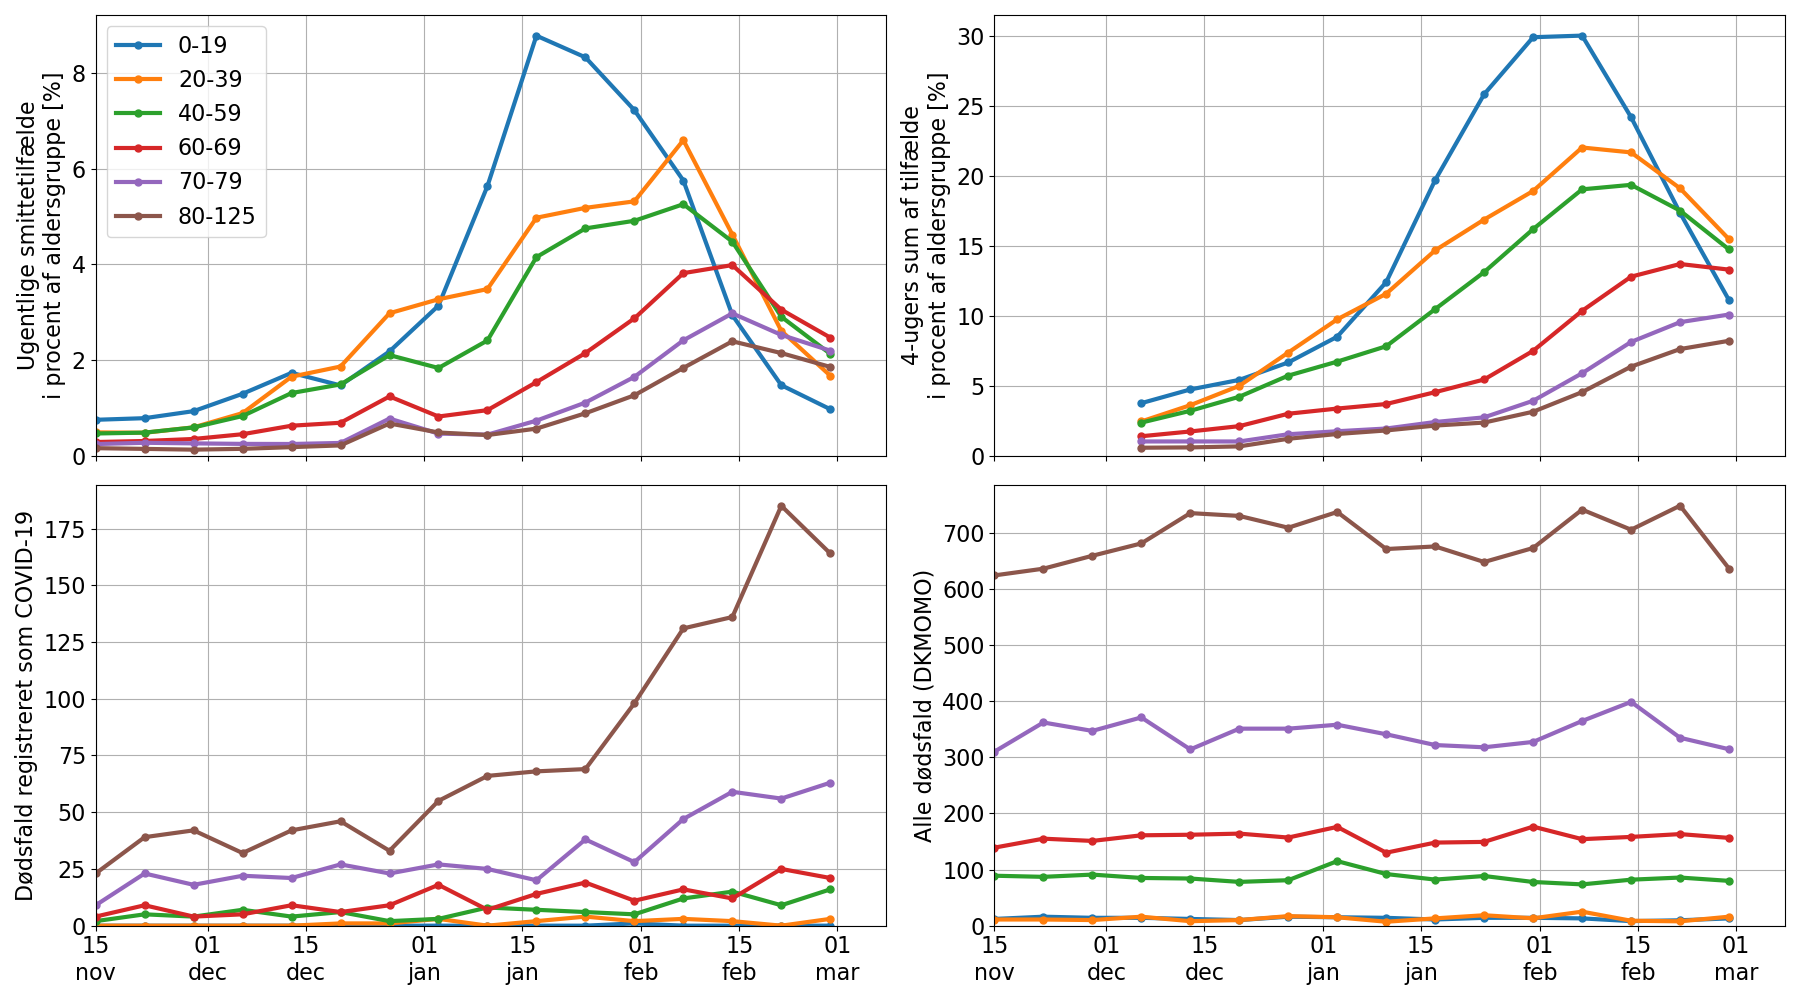

In [18]:
# allAgesCurrently = df_case.columns[1:]

# fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,15),sharex=True)
# for curAge in allAgesCurrently:
#     ax1.plot(df_case.Date,df_case[curAge],label=curAge)
#     ax2.plot(df_case.Date,df_case_rela[curAge],label=curAge)
#     ax3.plot(df_case_roll.Date,df_case_roll[curAge],label=curAge)
# ax1.legend()
# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)
# ax3.set_ylim(bottom=0)
# ax4.set_ylim(bottom=0)

# ax1.set_ylabel('Cases')
# ax2.set_ylabel('Cases relative to population')
# ax3.set_ylabel('Rolling sum of cases (4-weeks)')
# ax4.set_ylabel('All-cause mortality (EuroMOMO)')

# ax1.set_xlim(left=df_case.Date[0])

allAgesCurrently = df_case.columns[1:]

# fig,(ax1,ax2,ax3,ax4) = plt.subplots(4,1,figsize=(15,15),sharex=True)
fig,allAxes = plt.subplots(2,2,figsize=(18,10),sharex=True)
ax1,ax2,ax3,ax4 = allAxes.flatten()

# ax1_1 = ax1.twinx()

for curAge in allAgesCurrently:
    # ax1.plot(df_case.Date,df_case[curAge],'.-',label=curAge)
    ax1.plot(df_case.Date,100*df_case_rela[curAge],'.-',label=curAge)
    ax2.plot(df_case_roll.Date,100*df_case_roll[curAge],'.-',label=curAge)
    ax3.plot(df_case.Date,df_death[curAge],'.-',label=curAge)
    ax4.plot(df_allcause.Date,df_allcause[curAge],'.-',label=curAge)
ax1.legend(loc = 'upper left')
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)
ax3.set_ylim(bottom=0)
ax4.set_ylim(bottom=0)

# ax1.set_ylabel('Cases')
ax1.set_ylabel('Ugentlige smittetilfælde\ni procent af aldersgruppe [%]')
ax2.set_ylabel('4-ugers sum af tilfælde\ni procent af aldersgruppe [%]')
ax3.set_ylabel('Dødsfald registreret som COVID-19')
ax4.set_ylabel('Alle dødsfald (DKMOMO)')
# ax1.set_ylabel('Cases relative to population')
# ax2.set_ylabel('4-week sum of cases (relative)')
# ax3.set_ylabel('Deaths registrered as covid-deaths')
# ax4.set_ylabel('All-cause mortality (DKMOMO)')

ax1.set_xlim(left=df_case.Date[0],right=np.datetime64('today'))
ax1.grid()
ax2.grid()
ax3.grid()
ax4.grid()

ax1.xaxis.set_major_formatter(mdates.DateFormatter('%d\n%b'))

plt.tight_layout()

if saveFigures:
    plt.savefig('Figures/DataOverview')

# Viggo's metode

In [19]:
# df_case.columns[1:]
# 1-P

In [20]:
df_X = pd.DataFrame()
df_Y = pd.DataFrame()
df_D = pd.DataFrame()
df_C = pd.DataFrame()
df_P = pd.DataFrame()
df_PD = pd.DataFrame()
df_PX = pd.DataFrame() 

for curAge in df_case.columns[1:]:
    numRoll = len(df_case_roll)
    curDates = df_case['Date'].values[-numRoll:]
    cur_allcause = df_allcause[curAge].values[-numRoll:]

    cur_inci = df_case_roll[curAge].values
    cur_regiDeath = df_death[curAge].values[-numRoll:]

    D = cur_allcause
    C = cur_regiDeath
    P = cur_inci

    X = (D-C)/(1-P)
    Y = (C-(P*D))/(1-P)
    
    df_X[curAge] = X
    df_Y[curAge] = Y
    df_D[curAge] = D
    df_C[curAge] = C
    df_P[curAge] = P
    df_PD[curAge] = P*D
    df_PX[curAge] = P*X

In [21]:
# Correct to avoid negative values
df_X[df_C == 0] = df_D[df_C == 0] 
df_Y[df_C == 0] = 0
df_PX[df_C == 0] = 0 

df_Y[df_C < df_PX] = 0
# # df_X[df_C < df_PX] = df_D[df_C < df_PX] 
# df_C[df_C < df_PX] = df_PX[df_C < df_PX] 


df_X[df_C < df_PX] = df_D[df_C < df_PX] 
df_PX[df_C < df_PX] = df_C[df_C < df_PX] 

# df_X

In [22]:
len(df_Y)
# len(weekNamesShort)
curWeekNames = weekNamesShort[-len(df_Y):]
curWeekNames

df_Y_non = df_Y.copy()
df_Y_non[df_Y_non < 0] = 0
# df_Y_non

In [23]:
# df_Y[df_C == 0]

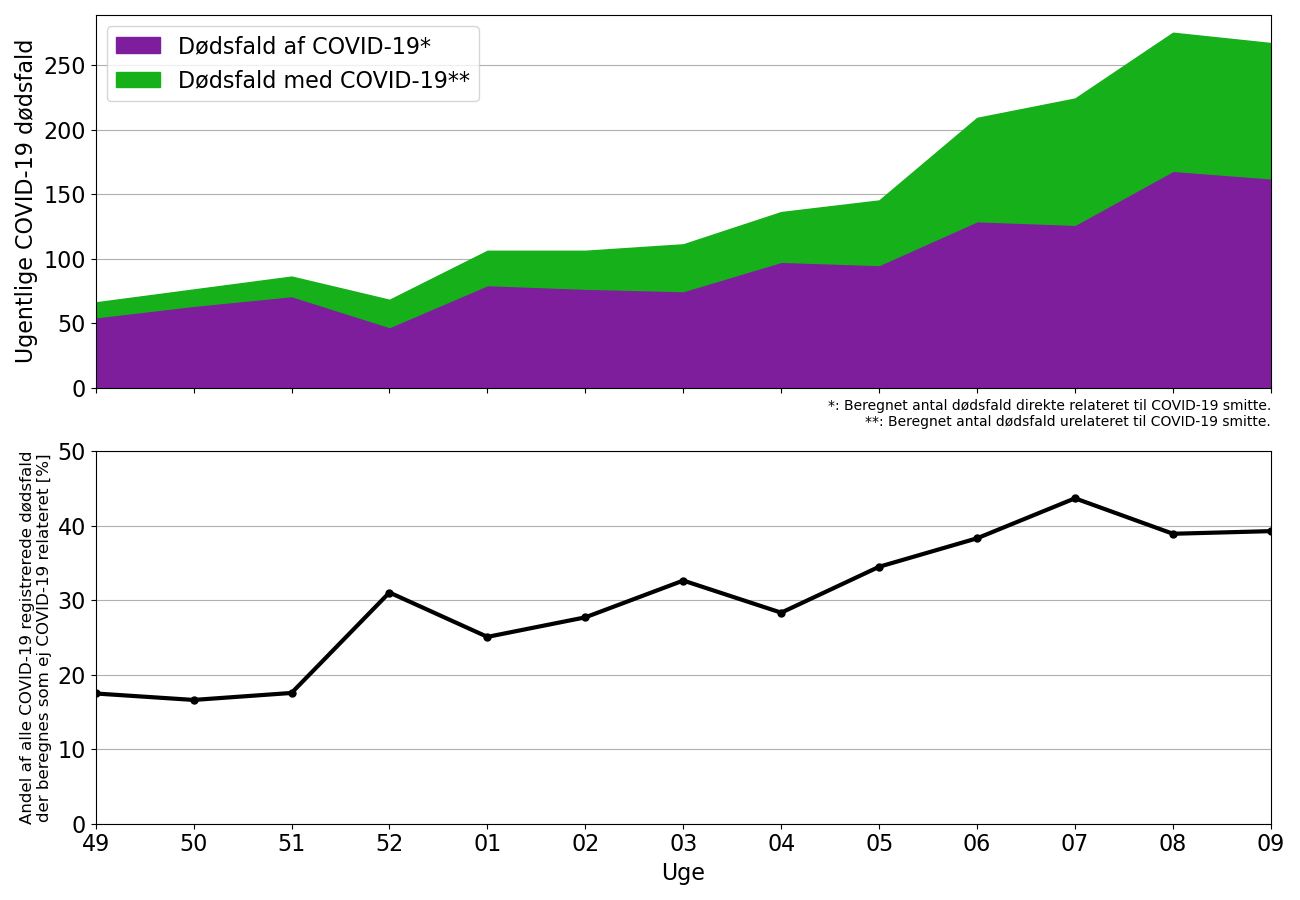

In [24]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(13,9))
curDates = df_case_roll.Date.values

curWeekNames = weekNamesShort[-len(df_Y):]
curDates = curWeekNames

Y_sum = df_Y.sum(axis=1)
Y_sum_non = df_Y_non.sum(axis=1)
C_sum = df_C.sum(axis=1)
D_sum = df_D.sum(axis=1)
X_sum = df_X.sum(axis=1)
ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Dødsfald af COVID-19*')
ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Dødsfald med COVID-19**')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Estimat for COVID-19 relaterede dødsfald')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Estimat for dødsfald ej relateret til COVID-19,\nmen med positiv PCR-test.')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='COVID-19 relaterede dødsfald*')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Ej COVID-19 relaterede dødsfald**')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='COVID-19 relaterede dødsfald')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Ej COVID-19 relaterede dødsfald')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Beregnede COVID-19 relaterede dødsfald.')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Beregnede dødsfald ej relateret til COVID-19,\nmen med positiv PCR-test.')
# ax1.plot(curDates,Y_sum_non,label='Y, no negative')
# ax1.plot(curDates,df_Y.sum(axis=1),label='Y')
# ax1.plot(curDates,df_C.sum(axis=1),label='C')
# # ax1.plot(curDates,C_sum,label='C')
# ax2.fill_between(curDates,100*np.ones(C_sum.shape),label='C')
# ax2.fill_between(curDates,100*(C_sum-Y_sum)/C_sum,label='C')
ax2.plot(curDates,100*(C_sum-Y_sum)/C_sum,'k.-',label='Andel af dødsfald med COVID-19')
# ax2.plot(curDates,100*(C_sum-Y_sum_non)/C_sum,label='No negative')
# ax1.plot(curDates,Y_sum,'Y')
# ax1.plot(curDates,Y_sum,'Y')

ax1.legend(loc='upper left')
# ax2.legend()
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)


# fig.suptitle('Hele befolkningen',fontsize=20)

ax1.set_ylabel('Ugentlige COVID-19 dødsfald')
# ax2.set_ylabel('Andel af dødsfald "med" COVID-19\naf de registrerede COVID-19-dødsfald [%]')
# ax2.set_ylabel('Dødsfald "med" COVID-19 i procent\naf alle COVID-19 dødsfald [%]')
ax2.set_ylabel('Andel af alle COVID-19 registrerede dødsfald\nder beregnes som ej COVID-19 relateret [%]',fontsize=12)
# ax2.set_ylim(top=100)
ax2.set_ylim(top=50)
ax1.set_xlim(left=curDates[0],right=curDates[-1])

ax2.set_xlabel('Uge')
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.set_axisbelow(True)


# txt1 = '*: Beregnet antal dødsfald direkte relateret til COVID-19 smitte.\n**: Beregnet antal dødsfald urelateret til COVID-19 smitte.'
txt1 = '*: Beregnet antal dødsfald direkte relateret til COVID-19 smitte.\n**: Beregnet antal dødsfald urelateret til COVID-19 smitte.'
ax1.text(1, -0.03,txt1,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax1.transAxes,
     fontsize=10)

plt.tight_layout()

if saveFigures:
    fig.savefig('Figures/CovidDødsfaldSamlet')

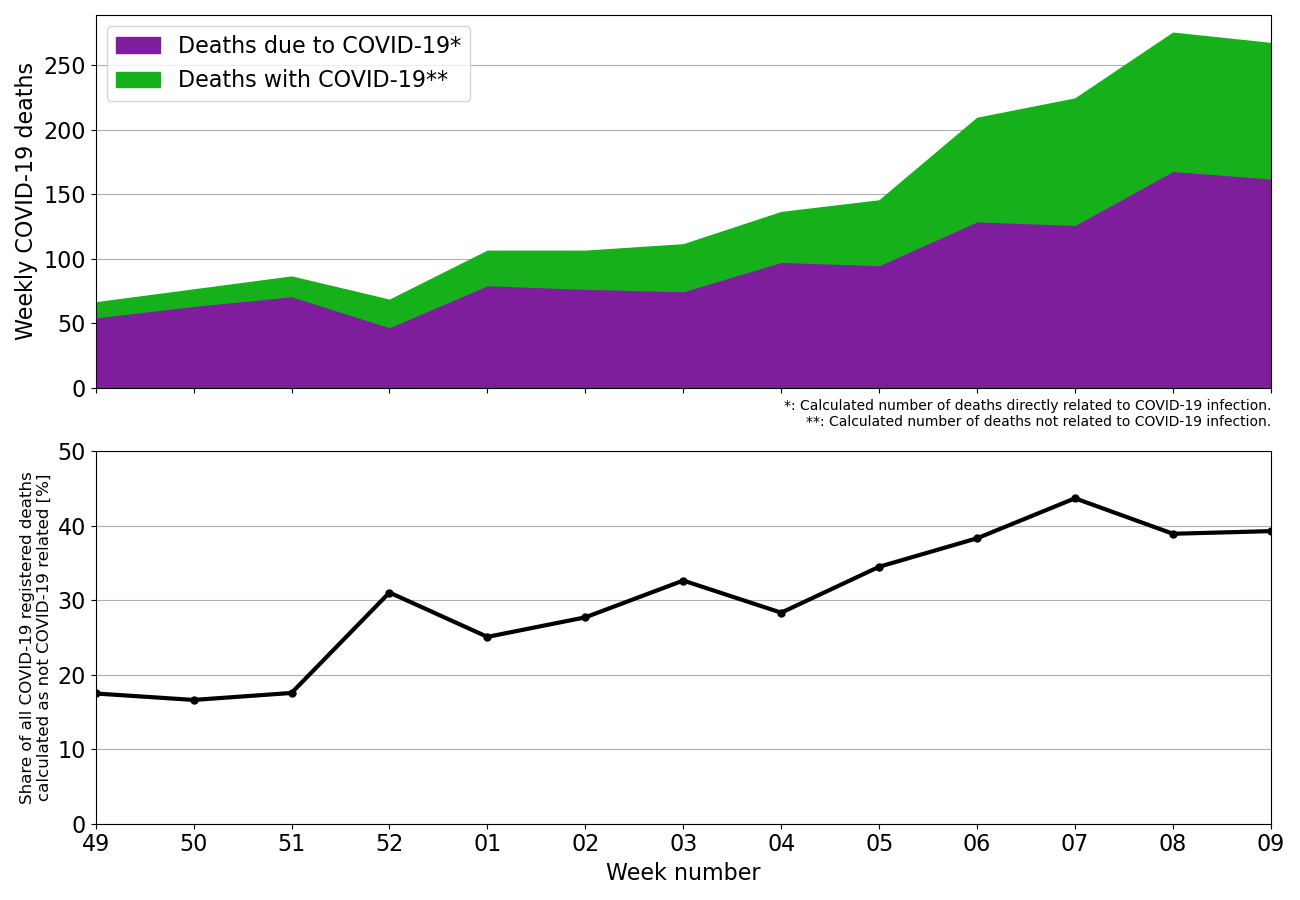

In [25]:
fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(13,9))
curDates = df_case_roll.Date.values

curWeekNames = weekNamesShort[-len(df_Y):]
curDates = curWeekNames

Y_sum = df_Y.sum(axis=1)
Y_sum_non = df_Y_non.sum(axis=1)
C_sum = df_C.sum(axis=1)
D_sum = df_D.sum(axis=1)
X_sum = df_X.sum(axis=1)
ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Deaths due to COVID-19*')
ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Deaths with COVID-19**')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Estimat for COVID-19 relaterede dødsfald')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Estimat for dødsfald ej relateret til COVID-19,\nmen med positiv PCR-test.')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='COVID-19 relaterede dødsfald*')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Ej COVID-19 relaterede dødsfald**')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='COVID-19 relaterede dødsfald')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Ej COVID-19 relaterede dødsfald')
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Beregnede COVID-19 relaterede dødsfald.')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Beregnede dødsfald ej relateret til COVID-19,\nmen med positiv PCR-test.')
# ax1.plot(curDates,Y_sum_non,label='Y, no negative')
# ax1.plot(curDates,df_Y.sum(axis=1),label='Y')
# ax1.plot(curDates,df_C.sum(axis=1),label='C')
# # ax1.plot(curDates,C_sum,label='C')
# ax2.fill_between(curDates,100*np.ones(C_sum.shape),label='C')
# ax2.fill_between(curDates,100*(C_sum-Y_sum)/C_sum,label='C')
ax2.plot(curDates,100*(C_sum-Y_sum)/C_sum,'k.-',label='Share of deaths with COVID-19')
# ax2.plot(curDates,100*(C_sum-Y_sum_non)/C_sum,label='No negative')
# ax1.plot(curDates,Y_sum,'Y')
# ax1.plot(curDates,Y_sum,'Y')

ax1.legend(loc='upper left')
# ax2.legend()
ax1.set_ylim(bottom=0)
ax2.set_ylim(bottom=0)


# fig.suptitle('Hele befolkningen',fontsize=20)

ax1.set_ylabel('Weekly COVID-19 deaths')
# ax2.set_ylabel('Andel af dødsfald "med" COVID-19\naf de registrerede COVID-19-dødsfald [%]')
# ax2.set_ylabel('Dødsfald "med" COVID-19 i procent\naf alle COVID-19 dødsfald [%]')
# ax2.set_ylabel('Andel af alle COVID-19 registrerede dødsfald\nder beregnes som ej COVID-19 relateret [%]',fontsize=12)
ax2.set_ylabel('Share of all COVID-19 registered deaths\ncalculated as not COVID-19 related [%]',fontsize=12)
# ax2.set_ylim(top=100)
ax2.set_ylim(top=50)
ax1.set_xlim(left=curDates[0],right=curDates[-1])

ax2.set_xlabel('Week number')
ax1.grid(axis='y')
ax2.grid(axis='y')
ax1.set_axisbelow(True)


# txt1 = '*: Beregnet antal dødsfald direkte relateret til COVID-19 smitte.\n**: Beregnet antal dødsfald urelateret til COVID-19 smitte.'
txt1 = '*: Calculated number of deaths directly related to COVID-19 infection.\n**: Calculated number of deaths not related to COVID-19 infection.'
ax1.text(1, -0.03,txt1,
     horizontalalignment='right',
     verticalalignment='top',
     transform = ax1.transAxes,
     fontsize=10)

plt.tight_layout()

if saveFigures:
    fig.savefig('Figures/CovidDeathsCombined')

In [26]:
df_to_save = pd.DataFrame()
df_to_save['Uge'] = weekNames[3:]
df_to_save['Dødsfald Total'] = C_sum
df_to_save['Dødsfald af COVID'] = Y_sum
df_to_save['Dødsfald med COVID'] = C_sum-Y_sum
df_to_save['Procent med COVID'] = 100*(C_sum-Y_sum)/C_sum

df_to_save.to_excel('COVID_doedsfald.xlsx',index=False)

df_to_save['Procent med COVID'] = np.round(10* 100*(C_sum-Y_sum)/C_sum)/10
# np.round(df_to_save.iloc[:,1:]*10)/10
df_to_save.iloc[:,2:-1] = np.round(df_to_save.iloc[:,2:-1]) 
df_to_save.iloc[:,2] = (df_to_save.iloc[:,2]).astype(int)
df_to_save.iloc[:,3] = (df_to_save.iloc[:,3]).astype(int)

df_to_save.to_excel('COVID_doedsfald_afrundet.xlsx',index=False)
display(df_to_save)
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Dødsfald af COVID-19')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Dødsfald med COVID-19')
# ax2.plot(curDates,100*(C_sum-Y_sum)/C_sum,'k.-',label='Andel af dødsfald med COVID-19')

Uge  Dødsfald Total  Dødsfald af COVID  Dødsfald med COVID  \
0   Uge 49-2021              66                 54                  12   
1   Uge 50-2021              76                 63                  13   
2   Uge 51-2021              86                 71                  15   
3   Uge 52-2021              68                 47                  21   
4   Uge 01-2022             106                 79                  27   
5   Uge 02-2022             106                 77                  29   
6   Uge 03-2022             111                 75                  36   
7   Uge 04-2022             136                 97                  39   
8   Uge 05-2022             145                 95                  50   
9   Uge 06-2022             209                129                  80   
10  Uge 07-2022             224                126                  98   
11  Uge 08-2022             275                168                 107   
12  Uge 09-2022             267                162                 105   

    Procent med COVID  
0                17.5  
1                16.6  
2                17.6  
3                31.0  
4                25.1  
5                27.7  
6                32.6  
7                28.3  
8                34.5  
9                38.3  
10               43.7  
11               38.9  
12               39.3

In [27]:
# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(13,9))
# curDates = df_case_roll.Date.values

# curWeekNames = weekNamesShort[-len(df_Y):]
# curDates = curWeekNames

# Y_sum = df_Y.sum(axis=1)
# Y_sum_non = df_Y_non.sum(axis=1)
# C_sum = df_C.sum(axis=1)
# D_sum = df_D.sum(axis=1)
# X_sum = df_X.sum(axis=1)
# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Dødsfald af COVID-19')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Dødsfald med COVID-19')
# # ax1.plot(curDates,Y_sum_non,label='Y, no negative')
# # ax1.plot(curDates,df_Y.sum(axis=1),label='Y')
# # ax1.plot(curDates,df_C.sum(axis=1),label='C')
# # # ax1.plot(curDates,C_sum,label='C')
# # ax2.fill_between(curDates,100*np.ones(C_sum.shape),label='C')
# # ax2.fill_between(curDates,100*(C_sum-Y_sum)/C_sum,label='C')
# ax2.plot(curDates,100*(C_sum-Y_sum)/C_sum,'k.-',label='Andel af dødsfald med COVID-19')
# # ax2.plot(curDates,100*(C_sum-Y_sum_non)/C_sum,label='No negative')
# # ax1.plot(curDates,Y_sum,'Y')
# # ax1.plot(curDates,Y_sum,'Y')

# ax1.legend(loc='upper left')
# # ax2.legend()
# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)


# fig.suptitle('Hele befolkningen',fontsize=20)

# ax1.set_ylabel('Ugentlige COVID-19 dødsfald')
# ax2.set_ylabel('Andel af dødsfald "med" COVID-19\naf de registrerede COVID-19-dødsfald [%]')
# # ax2.set_ylim(top=100)
# ax2.set_ylim(top=50)
# ax1.set_xlim(left=curDates[0],right=curDates[-1])

# ax2.set_xlabel('Uge')
# ax1.grid(axis='y')
# ax2.grid(axis='y')
# ax1.set_axisbelow(True)
# plt.tight_layout()

# if saveFigures:
#     fig.savefig('Figures/CovidDødsfaldSamlet')

In [28]:
# df_C
# # df_C_non
# # df_Y_non
# # df_Y_non
# df_Y

In [29]:
# df_C_non = df_C.copy()
# # df_C_non = df_C[df_Y < 0]
# df_C_non[df_Y < 0] = 0
# # df_C_non = df_C.copy()
# # df_C_non = df_C[df_Y < 0]

In [30]:
# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(13,9))
# curDates = df_case_roll.Date.values

# curWeekNames = weekNamesShort[-len(df_Y):]
# curDates = curWeekNames

# Y_sum = df_Y.sum(axis=1)
# Y_sum_non = df_Y_non.sum(axis=1)
# C_sum = df_C.sum(axis=1)
# C_sum_non = df_C_non.sum(axis=1)
# D_sum = df_D.sum(axis=1)
# X_sum = df_X.sum(axis=1)
# ax1.fill_between(curDates,Y_sum_non,color='xkcd:purple',label='Dødsfald af COVID-19')
# ax1.fill_between(curDates,C_sum_non,Y_sum_non,color='xkcd:green',label='Dødsfald med COVID-19')
# ax2.plot(curDates,100*(C_sum_non-Y_sum_non)/C_sum_non,'k.-',label='Andel af dødsfald med COVID-19')

# ax1.legend(loc='upper left')
# # ax2.legend()
# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

# fig.suptitle('Hele befolkningen, korrigeret for negative tal',fontsize=20)

# ax1.set_ylabel('Ugentlige COVID-19 dødsfald')
# ax2.set_ylabel('Andel af dødsfald med COVID-19\naf de registrerede COVID-19-dødsfald [%]')
# # ax2.set_ylim(top=100)
# ax2.set_ylim(top=50)
# ax1.set_xlim(left=curDates[0],right=curDates[-1])

# ax2.set_xlabel('Uge')
# ax1.grid(axis='y')
# ax2.grid(axis='y')
# ax1.set_axisbelow(True)
# plt.tight_layout()

# if saveFigures:
#     fig.savefig('Figures/CovidDødsfaldSamlet_NegativeKorrektion')

In [31]:
# df_Y.iloc[:,3:]

In [32]:
# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True,figsize=(13,9))
# curDates = df_case_roll.Date.values

# curWeekNames = weekNamesShort[-len(df_Y):]
# curDates = curWeekNames

# # Y_sum = df_Y.sum(axis=1)
# # Y_sum_non = df_Y_non.sum(axis=1)
# # C_sum = df_C.sum(axis=1)
# # D_sum = df_D.sum(axis=1)
# # X_sum = df_X.sum(axis=1)
# Y_sum = df_Y.iloc[:,3:].sum(axis=1)
# Y_sum_non = df_Y_non.iloc[:,3:].sum(axis=1)
# C_sum = df_C.iloc[:,3:].sum(axis=1)
# D_sum = df_D.iloc[:,3:].sum(axis=1)
# X_sum = df_X.iloc[:,3:].sum(axis=1)

# ax1.fill_between(curDates,Y_sum,color='xkcd:purple',label='Dødsfald af COVID-19')
# ax1.fill_between(curDates,C_sum,Y_sum,color='xkcd:green',label='Dødsfald med COVID-19')
# # ax1.plot(curDates,Y_sum_non,label='Y, no negative')
# # ax1.plot(curDates,df_Y.sum(axis=1),label='Y')
# # ax1.plot(curDates,df_C.sum(axis=1),label='C')
# # # ax1.plot(curDates,C_sum,label='C')
# # ax2.fill_between(curDates,100*np.ones(C_sum.shape),label='C')
# # ax2.fill_between(curDates,100*(C_sum-Y_sum)/C_sum,label='C')
# ax2.plot(curDates,100*(C_sum-Y_sum)/C_sum,'k.-',label='Andel af dødsfald med COVID-19')
# # ax2.plot(curDates,100*(C_sum-Y_sum_non)/C_sum,label='No negative')
# # ax1.plot(curDates,Y_sum,'Y')
# # ax1.plot(curDates,Y_sum,'Y')

# ax1.legend(loc='upper left')
# # ax2.legend()
# ax1.set_ylim(bottom=0)
# ax2.set_ylim(bottom=0)

# fig.suptitle('60 årige og op',fontsize=20)

# ax1.set_ylabel('Ugentlige COVID-19 dødsfald')
# ax2.set_ylabel('Andel af dødsfald "med" COVID-19\naf de registrerede COVID-19-dødsfald [%]')
# # ax2.set_ylim(top=100)
# ax2.set_ylim(top=50)
# ax1.set_xlim(left=curDates[0],right=curDates[-1])

# ax2.set_xlabel('Uge')
# ax1.grid(axis='y')
# ax2.grid(axis='y')
# ax1.set_axisbelow(True)
# plt.tight_layout()

# if saveFigures:
#     fig.savefig('Figures/CovidDødsfaldSamlet_60+')

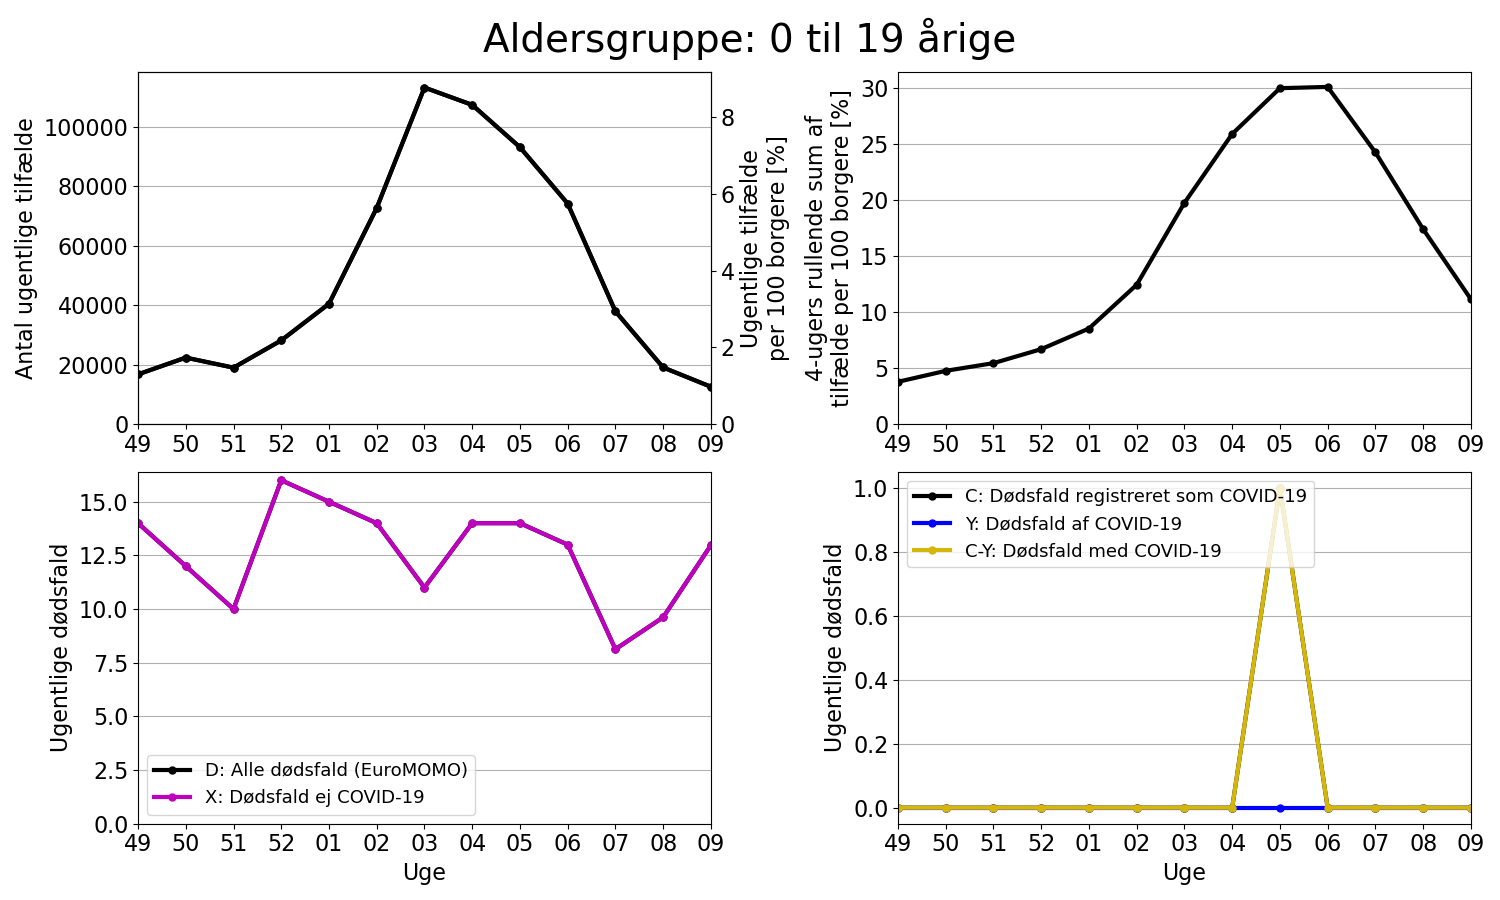

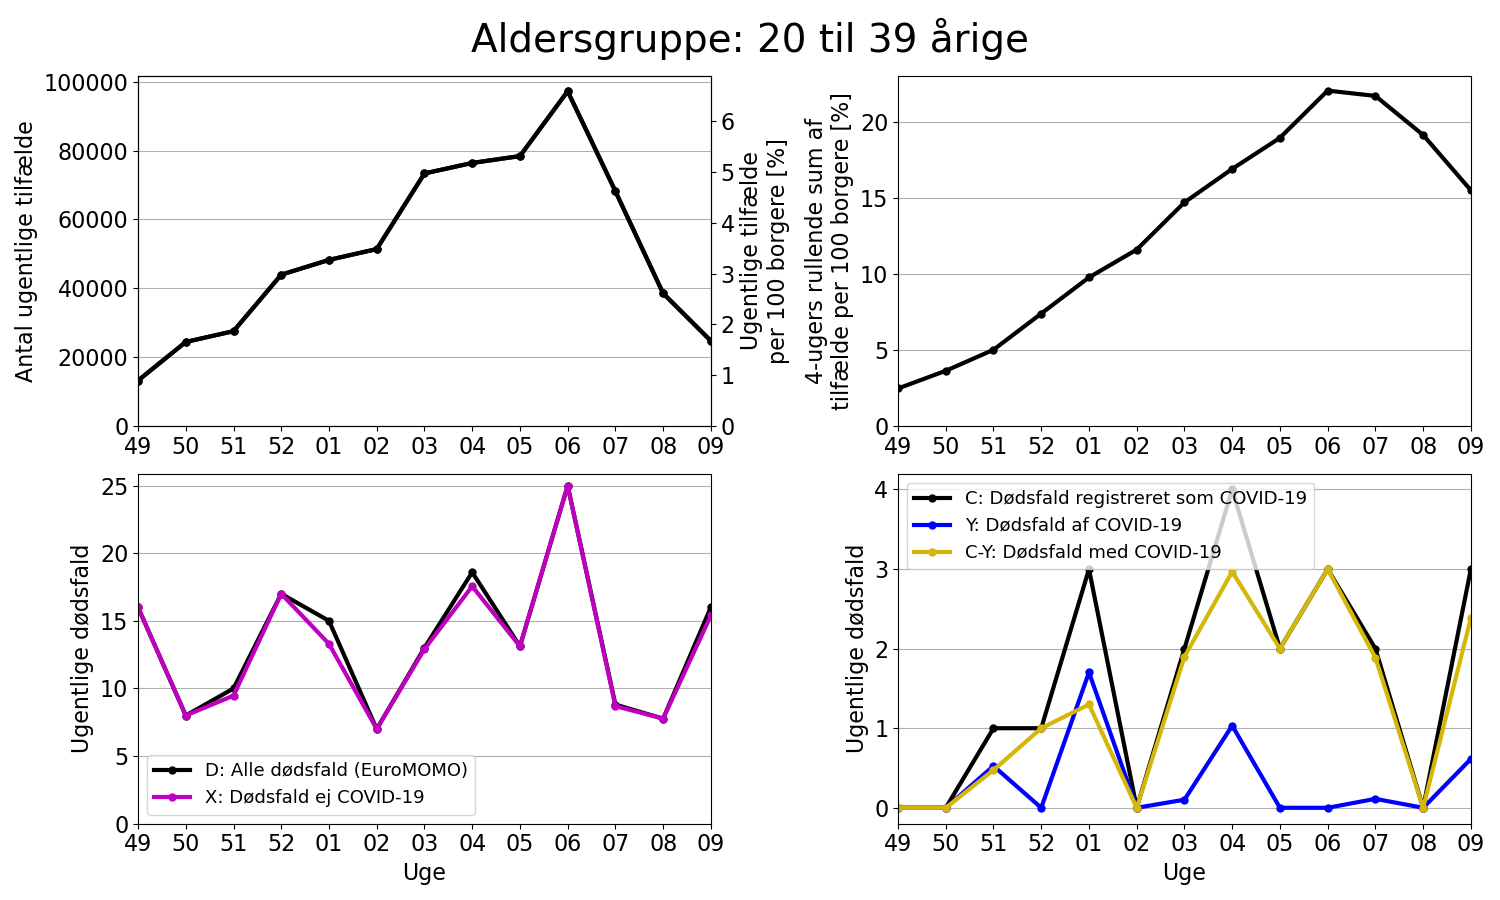

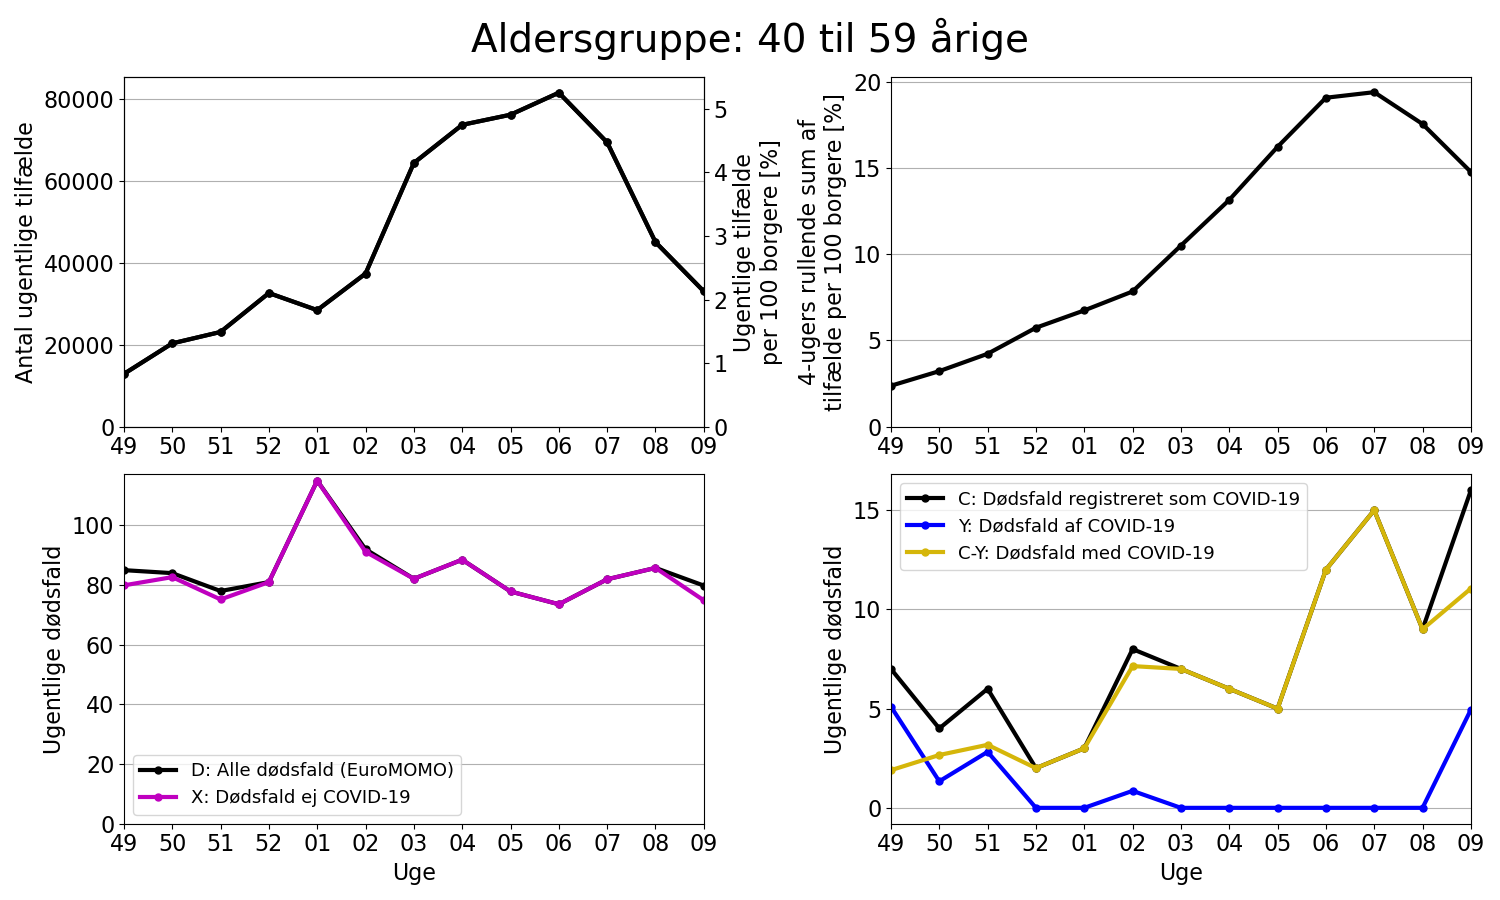

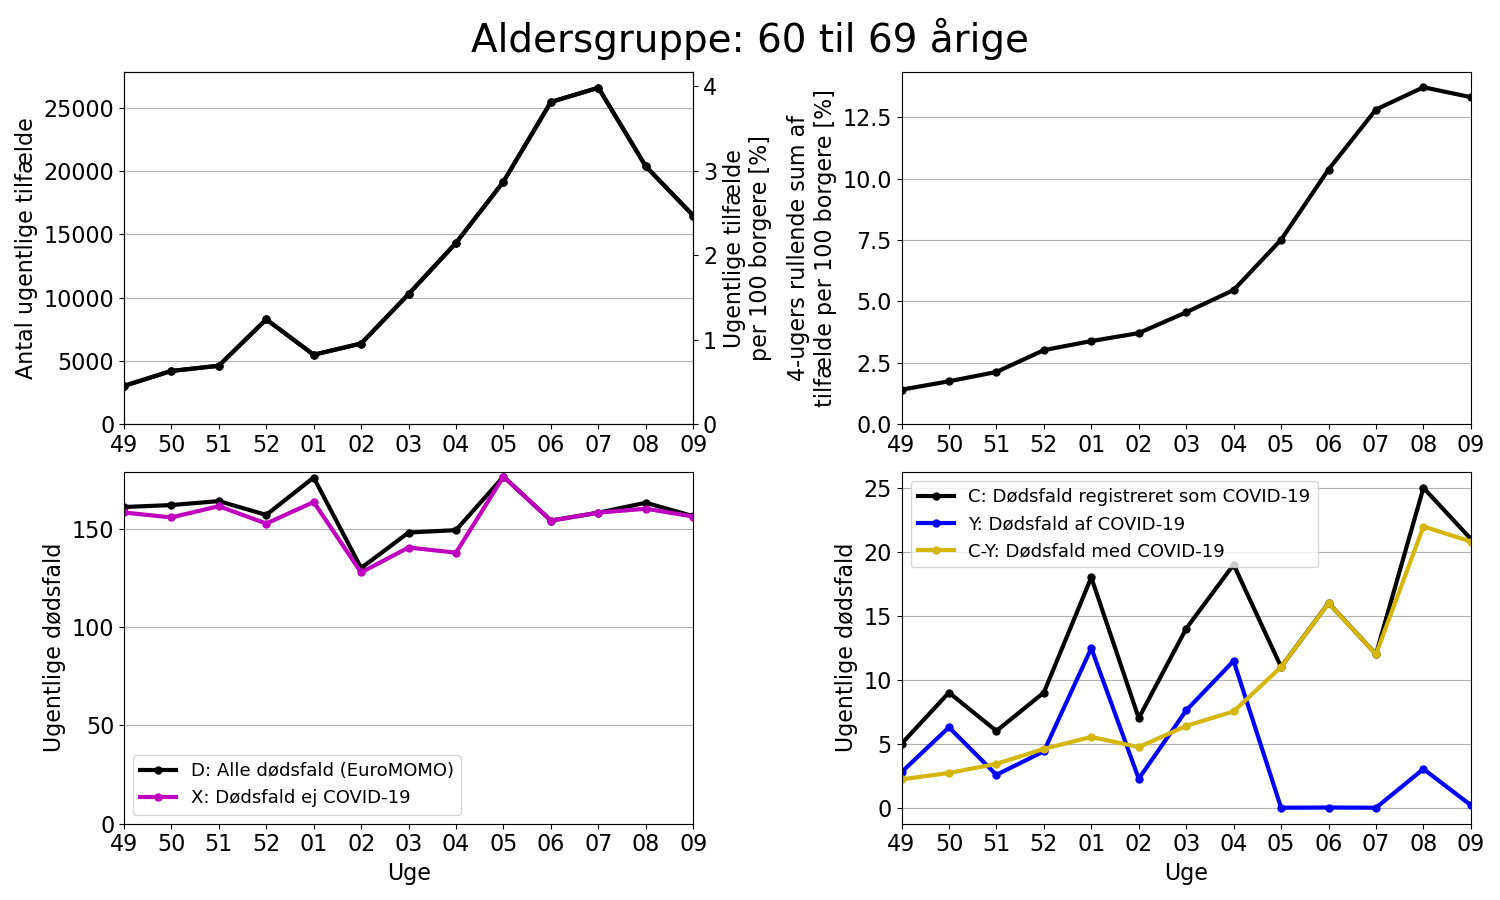

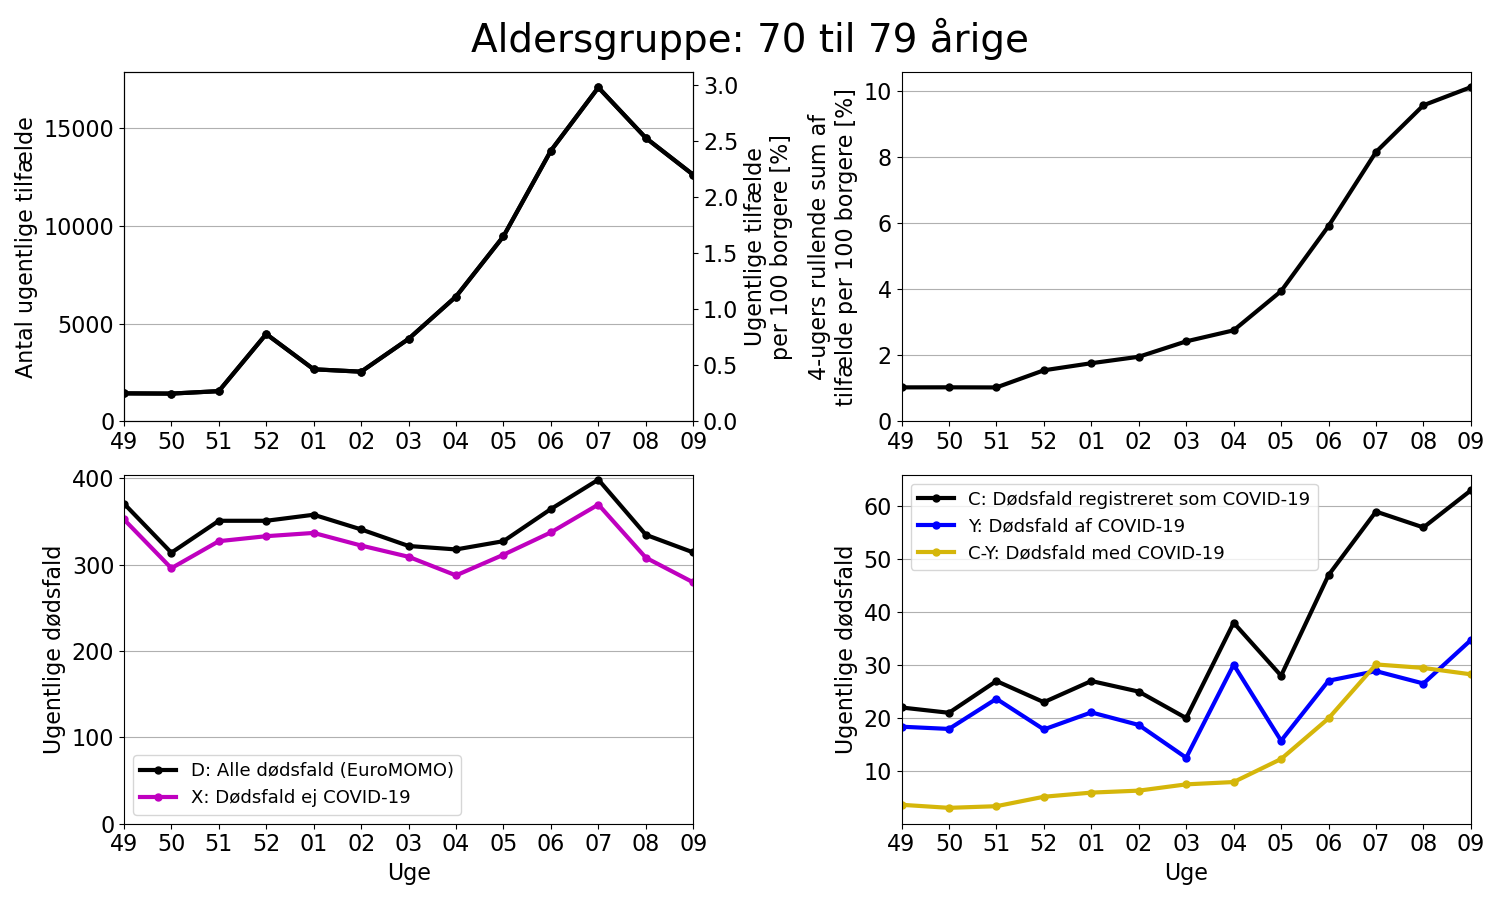

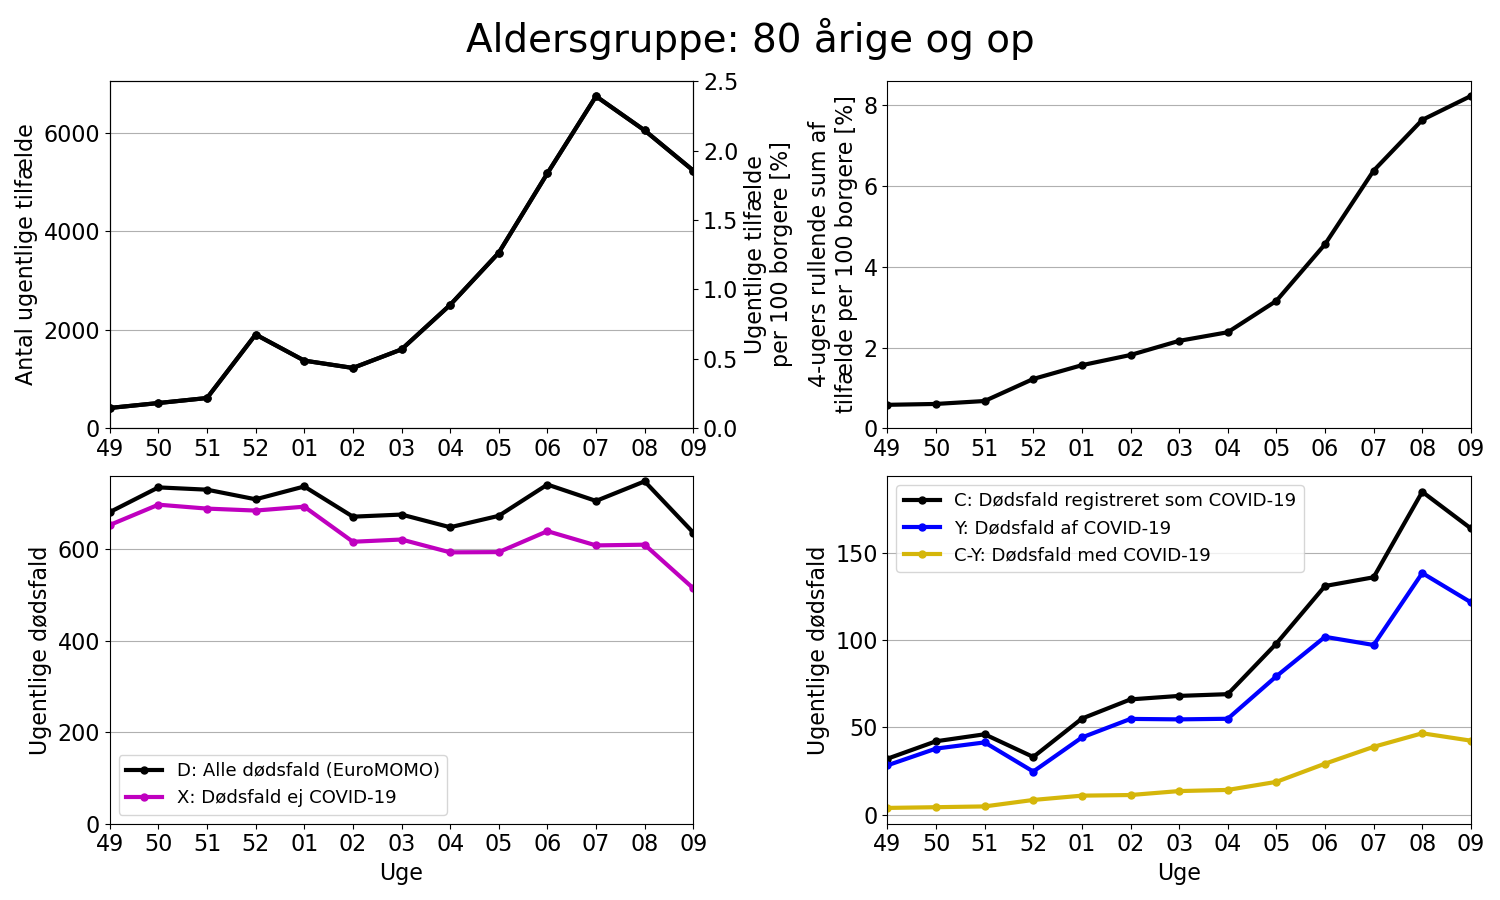

In [33]:
# curAge = '70-79'
plt.close('all')

for curAge in df_case.columns[1:]:
    curDates = df_case_roll.Date.values
    curWeekNames = weekNamesShort[-len(df_Y):]
    curDates = curWeekNames
    curDatesAll = weekNamesShort

    # fig,allAxes = plt.subplots(2,2,sharex=True)
    fig,allAxes = plt.subplots(2,2,figsize=(15,9))

    # ax1,ax2 = allAxes.flatten()
    # ax1,ax2,ax3,ax4 = allAxes.flatten()
    # ax4,ax3,ax1,ax2 = allAxes.flatten()
    ax3,ax4,ax1,ax2 = allAxes.flatten()

    ax3.plot(curDatesAll,df_case[curAge],'k.-')
    ax3_2 = ax3.twinx()
    ax3_2.plot(curDatesAll,100*df_case_rela[curAge],'k.-')

    ax4.plot(curDates,100*df_case_roll[curAge],'k.-')

    ax1.plot(curDates,df_D[curAge],'k.-',label='D: Alle dødsfald (EuroMOMO)')
    ax1.plot(curDates,df_X[curAge],'m.-',label='X: Dødsfald ej COVID-19')
    ax2.plot(curDates,df_C[curAge],'k.-',label='C: Dødsfald registreret som COVID-19')
    ax2.plot(curDates,df_Y[curAge],'b.-',label='Y: Dødsfald af COVID-19')
    ax2.plot(curDates,df_C[curAge]-df_Y[curAge],'.-',color='xkcd:dark yellow',label='C-Y: Dødsfald med COVID-19')

    ax1.legend(loc='lower left',fontsize=13)
    ax2.legend(loc='upper left',fontsize=13)

    ax1.set_ylim(bottom=0)
    # ax2.set_ylim(bottom=0)
    ax3.set_ylim(bottom=0)
    ax3_2.set_ylim(bottom=0)
    ax4.set_ylim(bottom=0)
    
    curLabel = 'Aldersgruppe: '
    if curAge == '80-125':
        curLabel = curLabel + '80 årige og op'
    else:
        curLabel = curLabel + curAge.split('-')[0] + ' til '+ curAge.split('-')[1] + ' årige'
    fig.suptitle(curLabel,fontsize=28)
    # fig.suptitle(f'Aldersgruppe: {curAge}',fontsize=28)

    ax1.grid(axis='y')
    ax2.grid(axis='y')
    ax3.grid(axis='y')
    ax4.grid(axis='y')

    ax1.set_ylabel('Ugentlige dødsfald')
    ax2.set_ylabel('Ugentlige dødsfald')
    ax3.set_ylabel('Antal ugentlige tilfælde')
    ax3_2.set_ylabel('Ugentlige tilfælde\nper 100 borgere [%]')
    ax4.set_ylabel('4-ugers rullende sum af\ntilfælde per 100 borgere [%]')

    ax1.set_xlim(left=curDates[0],right=curDates[-1])
    ax2.set_xlim(left=curDates[0],right=curDates[-1])
    ax3.set_xlim(left=curDatesAll[3],right=curDatesAll[-1])
    ax4.set_xlim(left=curDates[0],right=curDates[-1])

    ax1.set_xlabel('Uge')
    ax2.set_xlabel('Uge')

    plt.tight_layout()

    if saveFigures:
        fig.savefig(f'Figures/Overblik{curAge}')

In [34]:
# # curAge = '70-79'

# plt.close('all')

# for curAge in df_case.columns[1:]:
# # for curAge in df_case.columns[5:6]:
#     curDates = df_case_roll.Date.values
#     curWeekNames = weekNamesShort[-len(df_Y):]
#     curDates = curWeekNames
#     curDatesAll = weekNamesShort

#     # fig,allAxes = plt.subplots(2,2,sharex=True)
#     fig,allAxes = plt.subplots(2,2,figsize=(15,9))

#     # ax1,ax2 = allAxes.flatten()
#     # ax1,ax2,ax3,ax4 = allAxes.flatten()
#     # ax4,ax3,ax1,ax2 = allAxes.flatten()
#     ax3,ax4,ax1,ax2 = allAxes.flatten()

#     ax3.plot(curDatesAll,df_case[curAge],'k.-')
#     # ax3.errorbar(curDatesAll,df_case[curAge].values,np.sqrt(df_case[curAge].values),fmt='.-',color='k')
#     ax3_2 = ax3.twinx()
#     ax3_2.plot(curDatesAll,100*df_case_rela[curAge],'k.-')

#     ax4.plot(curDates,100*df_case_roll[curAge],'k.-')

#     # ax1.plot(curDates,df_D[curAge],'k.-',label='D: All-cause mortality (EuroMOMO)')
#     ax1.errorbar(curDates,df_D[curAge],2*np.sqrt(df_D[curAge]),fmt='.-',color='k',label='D: Alle dødsfald (EuroMOMO)',capsize=3,capthick=2,elinewidth=2)
#     ax1.plot(curDates,df_X[curAge],'m.-',label='X: Dødsfald ej COVID-19')
#     # ax2.plot(curDates,df_C[curAge],'k.-',label='C: Dødsfald registreret som COVID-19')
#     ax2.errorbar(curDates,df_C[curAge],2*np.sqrt(df_C[curAge]),fmt='.-',color='k',label='C: Dødsfald registreret som COVID-19',capsize=3,capthick=2,elinewidth=2)
#     ax2.plot(curDates,df_Y[curAge],'b.-',label='Y: Dødsfald af COVID-19')
#     ax2.plot(curDates,df_C[curAge]-df_Y[curAge],'.-',color='xkcd:dark yellow',label='C-Y: Dødsfald med COVID-19')

#     ax1.legend(loc='lower left',fontsize=13)
#     ax2.legend(loc='upper left',fontsize=13)

#     ax1.set_ylim(bottom=0)
#     # ax2.set_ylim(bottom=0)
#     ax3.set_ylim(bottom=0)
#     ax3_2.set_ylim(bottom=0)
#     ax4.set_ylim(bottom=0)
    
#     curLabel = 'Aldersgruppe: '
#     if curAge == '80-125':
#         curLabel = curLabel + '80 årige og op'
#     else:
#         curLabel = curLabel + curAge.split('-')[0] + ' til '+ curAge.split('-')[1] + ' årige'
#     fig.suptitle(curLabel,fontsize=28)
#     # fig.suptitle(f'Aldersgruppe: {curAge}',fontsize=28)

#     ax1.grid(axis='y')
#     ax2.grid(axis='y')
#     ax3.grid(axis='y')
#     ax4.grid(axis='y')

#     ax1.set_ylabel('Ugentlige dødsfald')
#     ax2.set_ylabel('Ugentlige dødsfald')
#     ax3.set_ylabel('Antal ugentlige tilfælde')
#     ax3_2.set_ylabel('Ugentlige tilfælde\nper 100 borgere [%]')
#     ax4.set_ylabel('4-ugers rullende sum af\ntilfælde per 100 borgere [%]')

#     ax1.set_xlim(left=curDates[0],right=curDates[-1])
#     ax2.set_xlim(left=curDates[0],right=curDates[-1])
#     ax3.set_xlim(left=curDatesAll[3],right=curDatesAll[-1])
#     ax4.set_xlim(left=curDates[0],right=curDates[-1])

#     ax1.set_xlabel('Uge')
#     ax2.set_xlabel('Uge')

#     plt.tight_layout()

#     if saveFigures:
#         fig.savefig(f'Figures\\OverblikUsikkerhed{curAge}')

In [35]:
np.sqrt(df_case[curAge].values)

array([21.26029163, 20.22374842, 19.10497317, 20.32240143, 22.64950331,
       24.79919354, 43.64630569, 37.08099244, 35.0142828 , 40.03748244,
       50.06995107, 59.72436689, 71.97916365, 82.14012418, 77.80102827,
       72.36711961])

In [36]:
# plt.close('all')
# curAge = '0-19'
# curAge = '20-39'
# curAge = '40-59'
# curAge = '60-69'
# # curAge = '70-125'
# curAge = '70-79'
# curAge = '80-125'

# numRoll = len(df_case_roll)
# curDates = df_case['Date'].values[-numRoll:]
# cur_allcause = df_allcause[curAge].values[-numRoll:]

# cur_inci = df_case_roll[curAge].values
# cur_regiDeath = df_death[curAge].values[-numRoll:]

# D = cur_allcause
# C = cur_regiDeath
# P = cur_inci

# X = (D-C)/(1-P)
# Y = (C-(P*D))/(1-P)

# # Y + X = D
# # Y + P*X = C 

# # Y + X - Y - P*X = D-C
# # (1-P)X = D-C 
# # X = (D-C)/(1-P)

# # Y + (D-C)/(1-P) = D
# # Y = D - (D-C)/(1-P) 
# # Y = [(1-P)D - D + C]/(1-P)
# # Y = [C-P*D]/(1-P)

# # C - Y = P*D

# # fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
# # ax1.plot(curDates,D,label='All cause mortality (D)')
# ax1.errorbar(curDates,D,np.sqrt(D),label='All cause mortality (D)')
# ax1.plot(curDates,X,label='Non-Covid mortality (X)')
# # ax2.plot(curDates,C,label='Registrered Covid mortality (C)')
# ax2.errorbar(curDates,C,np.sqrt(C),label='Registrered Covid mortality (C)')
# # ax2.plot(curDates,P*X,label='P*X')
# # ax2.plot(curDates,P*D,label='P*D')
# ax2.plot(curDates,Y,label='Actual Covid-mortality (Y)')
# # ax2.plot(curDates,C-Y,label='Misregistrations (C-Y)')
# ax2.errorbar(curDates,C-Y,np.sqrt(C-Y),label='Misregistrations (C-Y)')
# # ax3.fill_between(curDates,100*np.ones(C.shape),label='Covid')
# # ax3.fill_between(curDates,100*(C-Y)/C,label='Non-Covid')


# ax1.legend()
# ax2.legend()
# # ax3.legend()

# ax1.grid()
# ax2.grid()

# # ax3.set_ylim([0,50]) 
# ax1.set_ylim(bottom=0)

# # ax3.set_ylabel('Covid-registrered deaths [%]')

# if saveFigures:
#     fig.savefig(f'Figures/ViggoMetode_{curAge}')

In [37]:
# curAge = '0-19'
# # curAge = '20-39'
# # curAge = '40-59'
# # curAge = '60-69'
# # curAge = '70-125'

# numRoll = len(df_case_roll)
# curDates = df_case['Date'].values[-numRoll:]
# cur_allcause = df_allcause[curAge].values[-numRoll:]

# cur_inci = df_case_roll[curAge].values
# cur_regiDeath = df_death[curAge].values[-numRoll:]

# D = cur_allcause
# C = cur_regiDeath
# P = cur_inci

# X = (D-C)/(1-P)
# Y = (C-(P*D))/(1-P)
# X


# # fig,(ax1,ax2,ax3) = plt.subplots(3,1,sharex=True)
# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
# ax1.plot(curDates,P,label='P')
# # ax1.plot(curDates,X,label='Non-Covid mortality (X)')
# # ax2.plot(curDates,C,label='Registrered Covid mortality (C)')
# # ax2.plot(curDates,Y,label='Actual Covid-mortality (Y)')
# # ax2.plot(curDates,C-Y,label='Misregistrations (C-Y)')
# # ax3.fill_between(curDates,100*np.ones(C.shape),label='Covid')
# # ax3.fill_between(curDates,100*(C-Y)/C,label='Non-Covid')


# # ax1.legend()
# # ax2.legend()
# # # ax3.legend()

# # ax1.grid()
# # ax2.grid()

# # ax3.set_ylim([0,50]) 
# ax1.set_ylim(bottom=0)

# # ax3.set_ylabel('Covid-registrered deaths [%]')

# # if saveFigures:
# #     fig.savefig(f'Figures/ViggoMetode_{curAge}')

# Old below

In [50]:

# allMort,allMortDates = getAllCause(0,19)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curPop = getPopSizeNational(0,19)
# curRoll = [x.sum() for x in sliding_window_view(allCases_0_19, window_shape = 4)]
# curRollRela = curRoll/curPop

# DeathRandom_0_19 = allMort*curRollRela

In [51]:
# # getTimeSeriesAll()
# ssiAges = df2_C.Aldersgruppe.unique()
# print(ssiAges)
# firstAges = [int(x.split('-')[0]) for x in ssiAges[:-3]]
# firstAges.append(80)

# lastAges = [int(x.split('-')[1]) for x in ssiAges[:-3]]
# lastAges.append(125)
    
#     firstIndex = 0
#     lastIndex = -1

#     if (minAge == 95):
#         firstIndex = -2
#     elif (firstAge == minAge).any():
#         firstIndex = np.where(firstAge == minAge)[0][0]
#     else:
#         print('Incorrect minimum age, using 0')
        
#     if (maxAge == 125):
#         lastIndex = -1
#     elif (lastAge == maxAge).any():
#         lastIndex = np.where(lastAge == maxAge)[0][0]+1
#     else:
#         print('Incorrect maximum age, using maximum')


In [52]:
# allDeaths = getTimeSeries(df2_D,sNone)+getTimeSeries(df2_D,sOne)+getTimeSeries(df2_D,sTwo)
# allCases = getTimeSeries(df2_C,sNone)+getTimeSeries(df2_C,sOne)+getTimeSeries(df2_C,sTwo)

# # fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)
# # ax1.plot(allDates,allCases)
# # ax2.plot(allDates,allDeaths)

# # ax1.set_xlim([np.datetime64('2021-10'),np.datetime64('2022-03')])
# # ax1.grid()
# # ax2.grid()
# # ax2.set_ylim(bottom=0)

In [53]:
# # get
# # allCases = getTimeSeries(df2_C,sNone)+getTimeSeries(df2_C,sOne)+getTimeSeries(df2_C,sTwo)
# allCases_0_19 = getTimeSeriesAll(df2_C,'0-5') +getTimeSeriesAll(df2_C,'6-11') +getTimeSeriesAll(df2_C,'12-15') +getTimeSeriesAll(df2_C,'16-19') 
# # allCases_0_19 = getTimeSeriesAll(df2_C,'0-5') +getTimeSeriesAll(df2_C,'6-11') +getTimeSeriesAll(df2_C,'12-15') +getTimeSeriesAll(df2_C,'16-19') 
# # allCases_0_19 = getTimeSeriesAll(df2_C,'0-5') +getTimeSeriesAll(df2_C,'6-11') +getTimeSeriesAll(df2_C,'12-15') +getTimeSeriesAll(df2_C,'16-19') 
# # allCases_0_19 = getTimeSeriesAll(df2_C,'0-5') +getTimeSeriesAll(df2_C,'6-11') +getTimeSeriesAll(df2_C,'12-15') +getTimeSeriesAll(df2_C,'16-19') 
# allCases_0_19

# allMort,allMortDates = getAllCause(0,19)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curPop = getPopSizeNational(0,19)
# curRoll = [x.sum() for x in sliding_window_view(allCases_0_19, window_shape = 4)]
# curRollRela = curRoll/curPop

# DeathRandom_0_19 = allMort*curRollRela

In [54]:
# df2_C

In [55]:

# allCases_20_39 = getTimeSeriesAll(df2_C,'20-29') +getTimeSeriesAll(df2_C,'30-39')
# allCases_20_39

# allMort,allMortDates = getAllCause(20,39)
# curPop = getPopSizeNational(20,39)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curRoll = [x.sum() for x in sliding_window_view(allCases_20_39, window_shape = 4)]
# curRollRela = curRoll/curPop

# DeathRandom_20_39 = allMort*curRollRela

In [56]:

# allCases_40_64 = getTimeSeriesAll(df2_C,'40-49') +getTimeSeriesAll(df2_C,'50-59') +getTimeSeriesAll(df2_C,'60-64')
# allCases_40_64

# allMort,allMortDates = getAllCause(40,64)
# curPop = getPopSizeNational(40,64)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curRoll = [x.sum() for x in sliding_window_view(allCases_40_64, window_shape = 4)]
# curRollRela = curRoll/curPop

# DeathRandom_40_64 = allMort*curRollRela

In [57]:

# allCases_65_79 = getTimeSeriesAll(df2_C,'65-69') +getTimeSeriesAll(df2_C,'70-79')
# allCases_65_79

# allMort,allMortDates = getAllCause(65,79)
# curPop = getPopSizeNational(65,79)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curRoll = [x.sum() for x in sliding_window_view(allCases_65_79, window_shape = 4)]
# curRollRela = curRoll/curPop

# DeathRandom_65_79 = allMort*curRollRela

In [58]:


# allCases_80 = getTimeSeriesAll(df2_C,'80+') 
# allCases_80

# allMort,allMortDates = getAllCause(80,125)
# curPop = getPopSizeNational(80,125)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curRoll = [x.sum() for x in sliding_window_view(allCases_80, window_shape = 4)]
# curRollRela = curRoll/curPop

# DeathRandom_80 = allMort*curRollRela

In [59]:

# fig,ax1 = plt.subplots()

# ax1.plot(allMortDates,DeathRandom_0_19)
# ax1.plot(allMortDates,DeathRandom_20_39)
# ax1.plot(allMortDates,DeathRandom_40_64)
# ax1.plot(allMortDates,DeathRandom_65_79)
# ax1.plot(allMortDates,DeathRandom_80)
# ax1.plot(allMortDates,DeathRandom_0_19+DeathRandom_20_39+DeathRandom_40_64+DeathRandom_65_79+DeathRandom_80)

In [60]:
# allMort,allMortDates = getAllCause(0,19)
# allMort = allMort[-13:]
# allMortDates = allMortDates[-13:]
# curPop = getPopSizeNational(0,19)

# allCases_0_19
# from numpy.lib.stride_tricks import sliding_window_view

# curRoll = [x.sum() for x in sliding_window_view(allCases_0_19, window_shape = 4)]
# curRollRela = curRoll/curPop

# # curRoll/curPop

# fig,(ax1,ax2) = plt.subplots(2,1,sharex=True)

# ax1.plot(allDates[3:],curRollRela)
# ax2.plot(allMortDates,allMort)
# ax2.plot(allMortDates,allMort*curRollRela)

In [61]:
# allCases_0_19